# RNA e Deeplearning

Nome: Lucas Cavalcante Soares

e-mail: lcs4@cesar.school

Dataset:https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

## Importações

### Bibliotecas

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from google.colab import drive
import os
import cv2
import random
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import TensorDataset, random_split, DataLoader

In [17]:
!pip install opencv-python

### Dados

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_to_images  = '/content/drive/MyDrive/Rice_Image_Dataset'

In [18]:
subfolders = [f.path for f in os.scandir(path_to_images) if f.is_dir()]

In [19]:
subfolders = subfolders[:5]
subfolders

['/content/drive/MyDrive/Rice_Image_Dataset/Basmati',
 '/content/drive/MyDrive/Rice_Image_Dataset/Arborio',
 '/content/drive/MyDrive/Rice_Image_Dataset/Jasmine',
 '/content/drive/MyDrive/Rice_Image_Dataset/Ipsala',
 '/content/drive/MyDrive/Rice_Image_Dataset/Karacadag']

In [20]:
imgh = 64
imgw = 64

In [68]:
imagens = []
labels = []

num_images = 1000 # Quantidade de imagens por tipo de arroz

In [69]:
# Criando transformados para os dados.
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),  # Convertendo para escala de cinza
    transforms.Resize((imgh, imgw)),
    transforms.ToTensor(),
])

# Função para processar cada imagem
def process_image(path_image):
    image = cv2.imread(path_image)
    image_tensor = transform(image)
    return image_tensor, os.path.basename(path_image)

# Processamento em lote e paralelo
def process_images_in_batch(file_paths):
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = list(executor.map(process_image, file_paths))
    return results

In [70]:
# Pré-carregar os caminhos dos arquivos
file_paths = []
for folder in subfolders:
    files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    if len(files) > num_images:
        files = random.sample(files, num_images)
    file_paths.extend(files)

# Dividir os caminhos dos arquivos em lotes e processá-los
batch_size = 20  # Tamanho do lote
for i in range(0, len(file_paths), batch_size):
    batch_paths = file_paths[i:i+batch_size]
    batch_results = process_images_in_batch(batch_paths)
    for image_tensor, label in batch_results:
        imagens.append(image_tensor)
        labels.append(label)

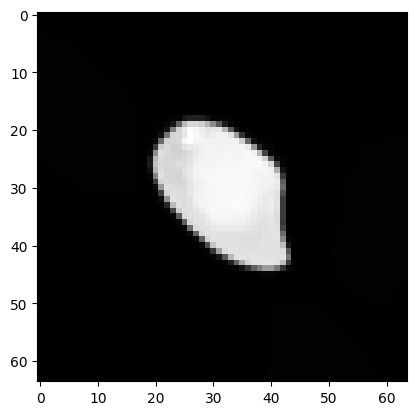

In [71]:
image_np = image_tensor.squeeze().numpy()  # Removendo dimensões de tamanho 1 e convertendo para NumPy
if image_np.max() <= 1:
    image_np = image_np * 255

# Usando plt.imshow para exibir a imagem
plt.imshow(image_np, cmap='gray')  # Especificando o mapa de cores para escala de cinza
plt.show()  # Exibindo a imagem


### Tratamento dos Dados

In [72]:
# Mapeamento dos tipos de arroz para categorias
tipo_arroz_map = {
    'Arborio': 0,
    'basmati': 1,
    'Ipsala': 2,
    'Jasmine': 3,
    'Karacadag': 4
}

# Criando a lista tipo_arroz
tipo_arroz = [tipo_arroz_map[label.split()[0]] for label in labels]
labels_tensor = tipo_arroz

# Verificando os valores únicos
set(labels_tensor)

{0, 1, 2, 3, 4}

In [73]:
# Usando uma lista de tuplas
dataset = [(imagem, rotulo) for imagem, rotulo in zip(imagens, labels_tensor)]

labels_tensor = torch.tensor(labels_tensor)
imagens_tensor = torch.stack(imagens)

torch.save(labels_tensor, 'labels_tensor.pt') # Convertendo em tensor
torch.save(imagens_tensor, 'imagens_tensor.pt')

dataset = TensorDataset(imagens_tensor, labels_tensor) # Definindo o dataset

In [ ]:
# Carregando os tensores salvos
# Caso já tenha os arquivos com os tensores, fazemos apenas o carregamento.
labels_tensor = torch.load('labels_tensor.pt')
imagens_tensor = torch.load('imagens_tensor.pt')

In [74]:
# Definindo o tamanho do conjunto de validação
valid_size = int(0.2 * len(dataset))  # 20% para validação
train_size = len(dataset) - valid_size  # O restante para treino

# Dividindo o dataset
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

## Criação da Rede

In [75]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 64, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 5)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net()

## Processo de treinamento e teste

In [76]:
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    loss_values = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

    # Calcula a média da perda ao final da época
    average_loss = running_loss / len(train_loader)
    loss_values.append(average_loss)  # Adiciona à lista de perdas

    return loss_values  # Retorna a lista de perdas ao final da função

In [77]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
          f"({accuracy:.0f}%)")

    evaluation = {
        'test_loss': test_loss,
        'accuracy': accuracy
    }
    return evaluation

In [80]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(1111)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 50}
test_kwargs = {'batch_size': 250}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(train_dataset, **train_kwargs)
val_loader = DataLoader(valid_dataset, **test_kwargs)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
log_interval = 10

evaluation = {'test_loss': [], 'train_loss': [], 'accuracy': []}

for epoch in range(1, epochs + 1):
    loss_values = train(log_interval, False, model, device, train_loader, optimizer, epoch)
    eval_result = test(model, device, val_loader)
    evaluation['train_loss'].append(loss_values)
    evaluation['test_loss'].append(eval_result['test_loss'])
    evaluation['accuracy'].append(eval_result['accuracy'])
    scheduler.step()

torch.save(model.state_dict(), "rice_classifier.pt")

Train Epoch: 1 [0/4000 (0%)]	Loss: 1.608559
Train Epoch: 1 [500/4000 (12%)]	Loss: 0.866559
Train Epoch: 1 [1000/4000 (25%)]	Loss: 0.394018
Train Epoch: 1 [1500/4000 (38%)]	Loss: 0.367522
Train Epoch: 1 [2000/4000 (50%)]	Loss: 0.372107
Train Epoch: 1 [2500/4000 (62%)]	Loss: 0.159033
Train Epoch: 1 [3000/4000 (75%)]	Loss: 0.322845
Train Epoch: 1 [3500/4000 (88%)]	Loss: 0.475453

Test set: Average loss: 0.2501, Accuracy: 885/1000 (88%)
Train Epoch: 2 [0/4000 (0%)]	Loss: 0.158259
Train Epoch: 2 [500/4000 (12%)]	Loss: 0.231520
Train Epoch: 2 [1000/4000 (25%)]	Loss: 0.179041
Train Epoch: 2 [1500/4000 (38%)]	Loss: 0.203944
Train Epoch: 2 [2000/4000 (50%)]	Loss: 0.172758
Train Epoch: 2 [2500/4000 (62%)]	Loss: 0.036844
Train Epoch: 2 [3000/4000 (75%)]	Loss: 0.344478
Train Epoch: 2 [3500/4000 (88%)]	Loss: 0.102986

Test set: Average loss: 0.1671, Accuracy: 937/1000 (94%)
Train Epoch: 3 [0/4000 (0%)]	Loss: 0.204539
Train Epoch: 3 [500/4000 (12%)]	Loss: 0.097091
Train Epoch: 3 [1000/4000 (25%)]	Lo

## Avaliação do modelo

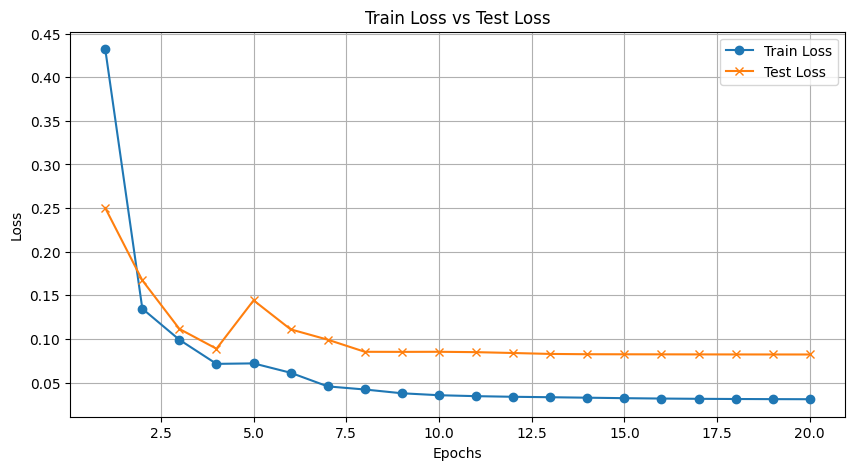

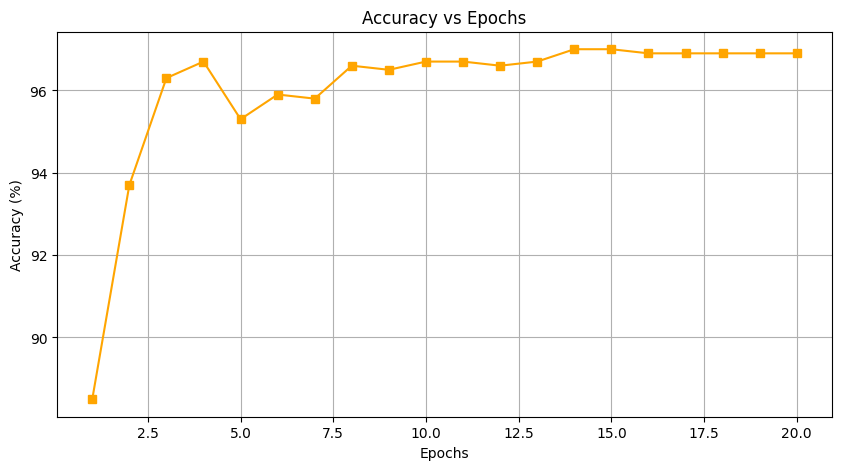

In [81]:
# Dados
epochs = range(1, len(evaluation['train_loss']) + 1)
train_loss = [item[0] for item in evaluation['train_loss']]
test_loss = evaluation['test_loss']
accuracy = evaluation['accuracy']

# Gráfico de train_loss vs test_loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Accuracy', marker='s', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.grid(True)
plt.show()

No início, enfrentou-se desafios na coleta de dados de imagens, pois o código apresentava baixa performance. Para resolver esse problema, realizou-se um pré-processamento dos caminhos dos arquivos e processou-se as imagens em lotes. Essa otimização resultou em significativa melhoria de desempenho.

Quanto ao modelo, optou-se por utilizar escala de cinza, uma vez que as imagens possuíam pouca ou nenhuma cor. Definiu-se o tamanho das imagens como 64x64 pixels e trabalhou-se com 5 rótulos (labels). Felizmente, a implementação da rede neural não apresentou grandes dificuldades.

Surpreendentemente, não foi necessário realizar ajustes para mitigar overfitting ou underfitting. Ao analisar o gráfico de perdas, observou-se que o modelo se comportou conforme o esperado. Após 20 épocas de treinamento, alcançou-se uma acurácia de 97%, o que é um resultado muito satisfatório.